In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Entendimento da base e análise exploratória dos dados (EDA)**

In [2]:
df = pd.read_csv("/home/marimartig/Documentos/mari/neurotech/base_case.csv", delimiter='\t')

In [3]:
df.head()

,index,alvo,REF_DATE,PRODUTO,DIAS_ATRASO,col_4,col_5,col_6,col_7,col_8,...,col_192,col_193,col_194,col_195,col_196,col_197,col_198,col_199,col_200,REGIAO
0,0,0,2023-01-31,CREDITO PESSOAL,52,2461.11,30 a 60,0,0,0,...,0,2,NaN,MEDIO,NaN,3.0,-1.0,1.0,URBANO,NORTE
1,1,0,2022-12-29,CREDITO PESSOAL,37,4674.50,30 a 60,0,0,0,...,0,4,D,MEDIO,D,2.0,1.0,1.0,URBANO,NORDESTE
2,2,0,2023-09-29,CREDITO PESSOAL,36,43649.17,30 a 60,1,0,0,...,0,8,B,MUITO ALTO,B+,4.0,3.0,1.0,URBANO,SUDESTE
3,3,1,2023-02-28,CREDITO PESSOAL,48,1090.58,30 a 60,0,0,0,...,0,1,C,BAIXO,C-,4.0,-4.0,0.0,URBANO,SUDESTE
4,4,0,2023-02-28,CREDITO PESSOAL,34,1495.49,30 a 60,0,0,0,...,0,3,C,MEDIO,C,4.0,-1.0,1.0,URBANO,SUDESTE


In [4]:
#valores ausentes em cada coluna: 
valores_ausentes = df.isnull().sum()

# filtrar apenas as colunas que têm valores ausentes:
valores_ausentes[valores_ausentes > 0]

col_51     4753
col_52     4753
col_53     4753
col_54     4753
col_55     4753
           ... 
col_197    4129
col_198    4148
col_199    3484
col_200    4859
REGIAO     4653
Length: 80, dtype: int64

In [5]:
# listar todas as colunas:
print(df.columns.tolist())

['index', 'alvo', 'REF_DATE', 'PRODUTO', 'DIAS_ATRASO', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28', 'col_29', 'col_30', 'col_31', 'col_32', 'col_33', 'col_34', 'col_35', 'col_36', 'col_37', 'col_38', 'col_39', 'col_40', 'col_41', 'col_42', 'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48', 'col_49', 'col_50', 'col_51', 'col_52', 'col_53', 'col_54', 'col_55', 'col_56', 'col_57', 'col_58', 'col_59', 'col_60', 'col_61', 'col_62', 'col_63', 'col_64', 'col_65', 'col_66', 'col_67', 'col_68', 'col_69', 'col_70', 'col_71', 'col_72', 'col_73', 'col_74', 'col_75', 'col_76', 'col_77', 'col_78', 'col_79', 'col_80', 'col_81', 'col_82', 'col_83', 'col_84', 'col_85', 'col_86', 'col_87', 'col_88', 'col_89', 'col_90', 'col_91', 'col_92', 'col_93', 'col_94', 'col_95', 'col_96', 'col_97', 'col_98', 

In [6]:
# verificando algumas colunas:
colunas_para_verificar = ['index', 'alvo', 'REF_DATE', 'DIAS_ATRASO']

#colunas e obter os valores únicos:
for coluna in colunas_para_verificar:
    valores_unicos = df[coluna].unique()
    print(f"Valores únicos da coluna '{coluna}': {valores_unicos}\n")

Valores únicos da coluna 'index': [    0     1     2 ... 46519 46520 46521]

Valores únicos da coluna 'alvo': [0 1]

Valores únicos da coluna 'REF_DATE': ['2023-01-31' '2022-12-29' '2023-09-29' '2023-02-28' '2022-11-30'
 '2023-03-31' '2023-07-31' '2023-11-30' '2023-04-28' '2023-06-30'
 '2023-05-31' '2023-08-31' '2023-10-31']

Valores únicos da coluna 'DIAS_ATRASO': [52 37 36 48 34 41 45 49 54 31 38 43 53 55 47 59 57 56 60 46 44 51 39 42
 58 35 50 33 40 32]



In [7]:
#distribuição da variável alvo: 
df['alvo'].value_counts(normalize=True)

alvo
0    0.871459
1    0.128541
Name: proportion, dtype: float64

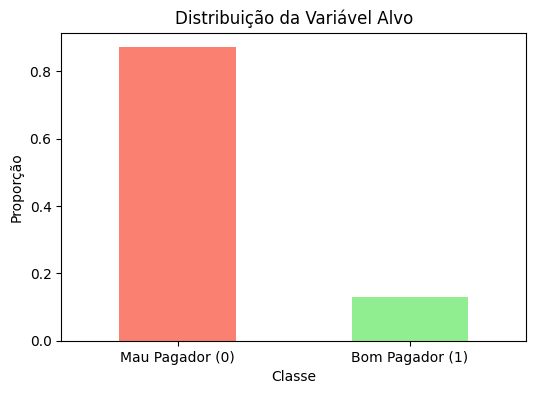

In [8]:
plt.figure(figsize=(6,4))
df['alvo'].value_counts(normalize=True).plot(kind='bar', color=['salmon', 'lightgreen'])
plt.title('Distribuição da Variável Alvo')
plt.xticks(ticks=[0, 1], labels=['Mau Pagador (0)', 'Bom Pagador (1)'], rotation=0)
plt.ylabel('Proporção')
plt.xlabel('Classe')
plt.show()

- A maioria dos registros (87.1%) está na classe de "Mau Pagador" (0), enquanto 12.9% estão na classe "Bom Pagador" 
- Isso indica que os dados estão desbalanceados.

In [8]:
# estatísticas descritivas da coluna DIAS_ATRASO: 
df['DIAS_ATRASO'].describe()[['mean', 'min', 'max']].round(2)

mean    45.23
min     31.00
max     60.00
Name: DIAS_ATRASO, dtype: float64

In [10]:
# Identificar colunas do tipo 'object' (categóricas):
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Colunas categóricas:", categorical_columns)

Colunas categóricas: ['REF_DATE', 'PRODUTO', 'col_5', 'col_79', 'col_80', 'col_81', 'col_82', 'col_83', 'col_84', 'col_85', 'col_86', 'col_117', 'col_118', 'col_119', 'col_120', 'col_121', 'col_122', 'col_143', 'col_144', 'col_145', 'col_146', 'col_147', 'col_148', 'col_149', 'col_152', 'col_153', 'col_154', 'col_155', 'col_157', 'col_158', 'col_159', 'col_161', 'col_162', 'col_163', 'col_168', 'col_171', 'col_172', 'col_178', 'col_180', 'col_181', 'col_184', 'col_185', 'col_186', 'col_194', 'col_195', 'col_196', 'col_200', 'REGIAO']


In [11]:
#valores únicos da coluna 'REGIAO': 
unique_regiao_values = df['REGIAO'].unique()
print("Valores únicos na coluna REGIAO:")
print(unique_regiao_values)

Valores únicos na coluna REGIAO:
['NORTE' 'NORDESTE' 'SUDESTE' 'CENTRO-OESTE' nan 'SUL']


In [12]:
# transformação da coluna 'REGIAO' em numérica: 
df['REGIAO'], uniques = pd.factorize(df['REGIAO'])

#valores transformados: 
print("Valores numéricos na coluna REGIAO:")
print(df['REGIAO'].unique())

Valores numéricos na coluna REGIAO:
[ 0  1  2  3 -1  4]


In [13]:
# Exibir os valores únicos da coluna 'REF_DATE'
unique_ref_date_values = df['REF_DATE'].unique()
print("Valores únicos na coluna REF_DATE:")
print(unique_ref_date_values)


Valores únicos na coluna REF_DATE:
['2023-01-31' '2022-12-29' '2023-09-29' '2023-02-28' '2022-11-30'
 '2023-03-31' '2023-07-31' '2023-11-30' '2023-04-28' '2023-06-30'
 '2023-05-31' '2023-08-31' '2023-10-31']


In [14]:
# transformar a coluna 'REF_DATE' para tipo datetime: 
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])


df['ANO'] = df['REF_DATE'].dt.year
df['MES'] = df['REF_DATE'].dt.month
df['DIA'] = df['REF_DATE'].dt.day
df['DIA_DA_SEMANA'] = df['REF_DATE'].dt.dayofweek 

In [15]:
# Exibindo os valores únicos das colunas 'col_171' e 'col_181'
unique_col_171 = df['col_171'].unique()
unique_col_181 = df['col_181'].unique()

print("Valores únicos na coluna col_171:")
print(unique_col_171)

print("Valores únicos na coluna col_181:")
print(unique_col_181)

Valores únicos na coluna col_171:
['FUNDAMENTAL COMPLETO' 'SUPERIOR INCOMPLETO' 'SUPERIOR COMPLETO' nan
 'MEDIO COMPLETO' 'MEDIO INCOMPLETO' 'FUNDAMENTAL INCOMPLETO'
 'PRIMARIO COMPLETO' 'DOUTORADO COMPLETO' 'PRIMARIO INCOMPLETO'
 'ANALFABETO' 'MESTRADO COMPLETO' 'ENSINO MEDIO COMPLETO']
Valores únicos na coluna col_181:
[nan 'MEDICO' 'PSICOLOGO' 'ENGENHEIRO' 'CONSULTOR FINANCEIRO' 'ARQUITETO'
 'CONTADOR' 'CORRETOR_DE_IMOVEIS' 'DENTISTA' 'CORRETOR_DE_SEGUROS'
 'VETERINARIO' 'FISIOTERAPEUTA' 'ADVOGADO' 'GUIA_TURISTICO' 'FARMACEUTICO']


In [16]:
# Transformando a coluna 'col_171' em numérica
df['col_171'], uniques_col_171 = pd.factorize(df['col_171'])

# Transformando a coluna 'col_181' em numérica
df['col_181'], uniques_col_181 = pd.factorize(df['col_181'])

# Exibindo os valores transformados
print("Valores numéricos na coluna col_171:")
print(df['col_171'].unique())

print("Valores numéricos na coluna col_181:")
print(df['col_181'].unique())

Valores numéricos na coluna col_171:
[ 0  1  2 -1  3  4  5  6  7  8  9 10 11]
Valores numéricos na coluna col_181:
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


**Pré-processamento das variáveis**

In [19]:
# definindo as variáveis independentes (X) e a variável alvo (y):
X = df[['REGIAO', 'col_171', 'col_181', 'DIAS_ATRASO']] 
y = df['alvo']

In [20]:
# dividindo os dados em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Modelo LightGBM:**

In [21]:
# inicializando o modelo
model = lgb.LGBMClassifier()

In [22]:
# Treinando o modelo
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4784, number of negative: 32433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 37217, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128543 -> initscore=-1.913899
[LightGBM] [Info] Start training from score -1.913899


LGBMClassifier()

In [23]:
# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

In [24]:
# avaliando o desempenho do modelo
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Matriz de Confusão:
[[8107    2]
 [1195    1]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8109
           1       0.33      0.00      0.00      1196

    accuracy                           0.87      9305
   macro avg       0.60      0.50      0.47      9305
weighted avg       0.80      0.87      0.81      9305



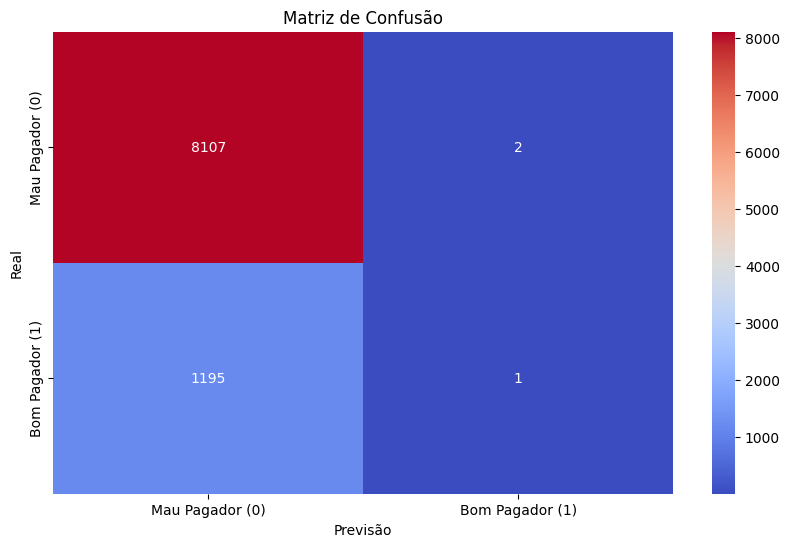

In [25]:
cm = confusion_matrix(y_test, y_pred)

# Criando um gráfico de calor (heatmap) para a matriz de confusão
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', 
             xticklabels=['Mau Pagador (0)', 'Bom Pagador (1)'], 
             yticklabels=['Mau Pagador (0)', 'Bom Pagador (1)'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

Ajuste de hiperparâmetros:

In [26]:
# definindo os parâmetros para ajuste:
param_grid = {
    'num_leaves': [31],
    'max_depth': [-1],
    'learning_rate': [0.05],
    'n_estimators': [50, 100]
}

In [27]:
lgbm = LGBMClassifier()
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, 
                            scoring='f1', cv=5, verbose=1, n_jobs=1)  

In [28]:
# Treinando com uma amostra
X_sample = X_train.sample(frac=0.1, random_state=42)
y_sample = y_train.sample(frac=0.1, random_state=42)

grid_search.fit(X_sample, y_sample)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 368, number of negative: 2609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 2977, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123614 -> initscore=-1.958639
[LightGBM] [Info] Start training from score -1.958639
[LightGBM] [Info] Number of positive: 368, number of negative: 2609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 2977,

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [-1],
                         'n_estimators': [50, 100], 'num_leaves': [31]},
             scoring='f1', verbose=1)

In [29]:
# melhores parâmetros
print("Melhores hiperparâmetros encontrados: ", grid_search.best_params_)


Melhores hiperparâmetros encontrados:  {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 31}


Treinando o modelo com hiperparâmetros otimizados:

In [30]:
# inicializando o modelo com os melhores hiperparâmetros:
best_lgbm = LGBMClassifier(
    learning_rate=0.05,
    max_depth=-1,
    n_estimators=50,
    num_leaves=31
)

In [31]:
# modelo com os dados de treino
best_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4784, number of negative: 32433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 37217, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128543 -> initscore=-1.913899
[LightGBM] [Info] Start training from score -1.913899


LGBMClassifier(learning_rate=0.05, n_estimators=50)

In [32]:
# Fazendo previsões no conjunto de teste
y_pred = best_lgbm.predict(X_test)

# Gerando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# Gerando o relatório de classificação
report = classification_report(y_test, y_pred)
print("Relatório de Classificação:")
print(report)

Matriz de Confusão:
[[8109    0]
 [1196    0]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8109
           1       0.00      0.00      0.00      1196

    accuracy                           0.87      9305
   macro avg       0.44      0.50      0.47      9305
weighted avg       0.76      0.87      0.81      9305



/home/marimartig/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marimartig/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marimartig/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


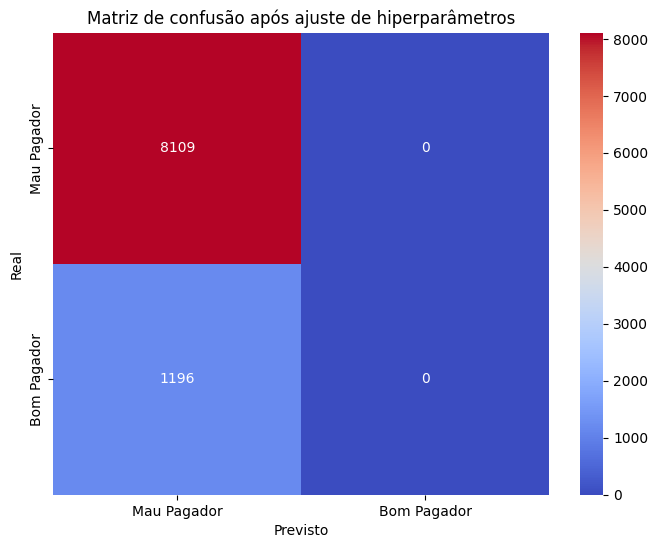

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', 
            xticklabels=['Mau Pagador', 'Bom Pagador'], 
            yticklabels=['Mau Pagador', 'Bom Pagador'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de confusão após ajuste de hiperparâmetros')
plt.show()

curva ROC para LightGBM:

In [35]:
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilidades para a classe "Bom Pagador"
fpr, tpr, thresholds = roc_curve(y_test, y_probs)  # Calcula FPR e TPR
roc_auc = auc(fpr, tpr)  # Área sob a curva ROC

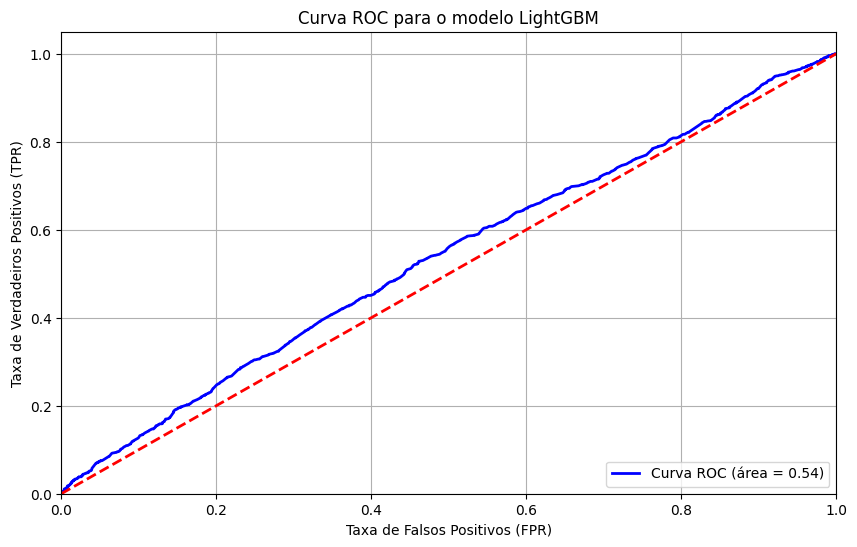

In [37]:
# Plotar a curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC para o modelo LightGBM')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Modelo Random Forest:** 

In [38]:
# Definindo as variáveis independentes (X) e a variável alvo (y)
X = df[['REGIAO', 'col_171', 'col_181', 'DIAS_ATRASO']] 
y = df['alvo']

In [39]:
_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [40]:
# Criar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
# Fazer previsões
y_pred = rf_model.predict(X_test)

In [42]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Relatório de Classificação
report = classification_report(y_test, y_pred)

print("Matriz de Confusão:")
print(cm)
print("\nRelatório de Classificação:")
print(report)

Matriz de Confusão:
[[8070   39]
 [1187    9]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8109
           1       0.19      0.01      0.01      1196

    accuracy                           0.87      9305
   macro avg       0.53      0.50      0.47      9305
weighted avg       0.78      0.87      0.81      9305



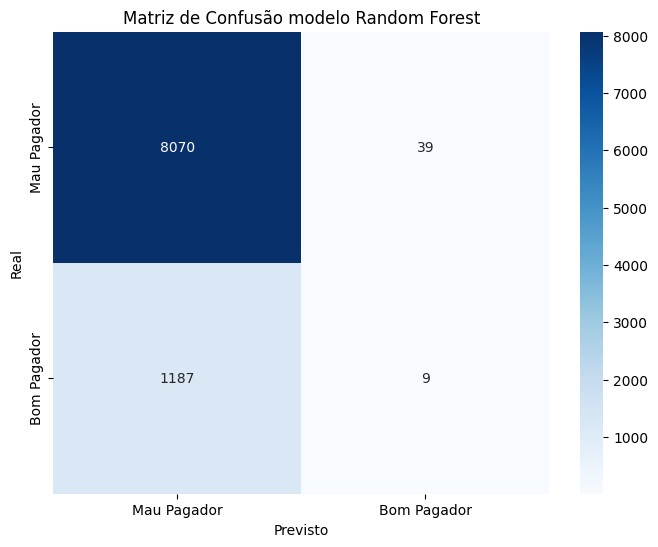

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mau Pagador', 'Bom Pagador'], 
            yticklabels=['Mau Pagador', 'Bom Pagador'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão modelo Random Forest')
plt.show()